# Image Classification Project


In [1]:
!pip install opencv-python

In [2]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# (1) Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

Now how do you detect face and eyes?

We will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

In [3]:
img = cv2.imread('../model/test_images/anny3.jpg')
if img is None:
    print("Can't find any image !!")
img.shape

(2576, 1932, 3)

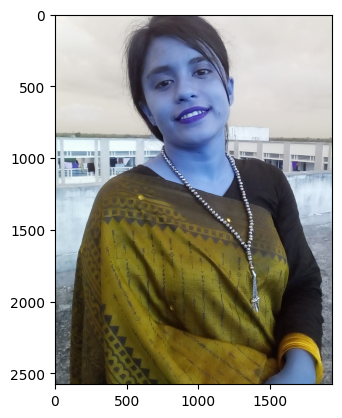

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(2576, 1932)

In [6]:
gray

array([[224, 230, 243, ..., 228, 228, 226],
       [230, 235, 245, ..., 225, 228, 227],
       [243, 245, 246, ..., 229, 229, 223],
       ...,
       [ 81,  79,  77, ..., 145, 139, 136],
       [ 82,  93,  91, ..., 160, 158, 168],
       [ 86, 113, 111, ..., 144, 143, 160]], dtype=uint8)

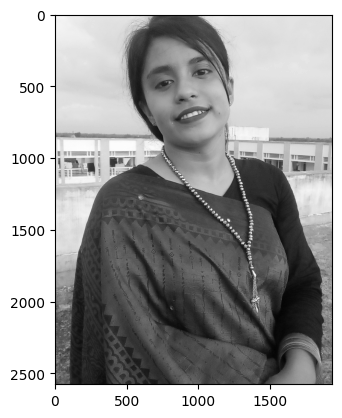

In [7]:
plt.imshow(gray, cmap='gray')

In [8]:
face_cascade = cv2.CascadeClassifier('opencv\\haarcascades\\haarcascade_frontalface_default.xml')
print(face_cascade)
eye_cascade = cv2.CascadeClassifier('opencv\\haarcascades\\haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 9)
faces

< cv2.CascadeClassifier 00000245B78E31B0>


array([[502, 122, 781, 781]], dtype=int32)

In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(502), np.int32(122), np.int32(781), np.int32(781))

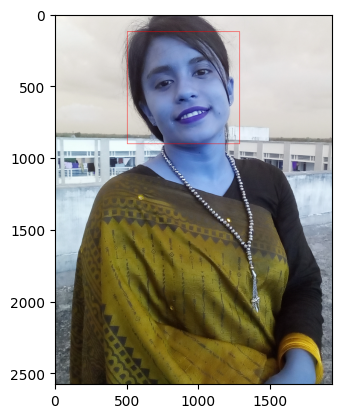

In [10]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

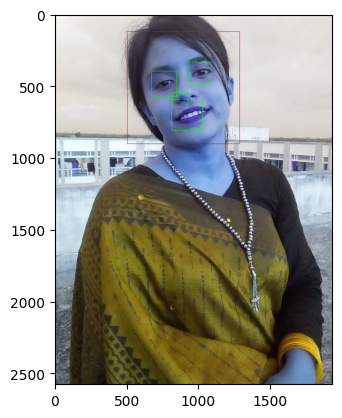

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

# (2) Preprocessing: Crop the facial region of the image

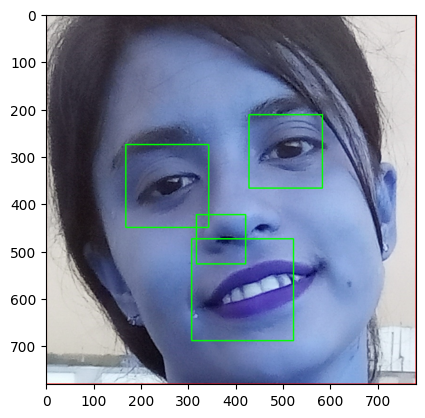

In [12]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [13]:
cropped_img = np.array(roi_color)
cropped_img.shape

(781, 781, 3)

# (3) Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc


Wavelet transform : 

In [14]:
pip install PyWavelets


Note: you may need to restart the kernel to use updated packages.


In [15]:
!pip install PyWavelets


In [16]:
import numpy as np
import pywt  #py wavelet transform library
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

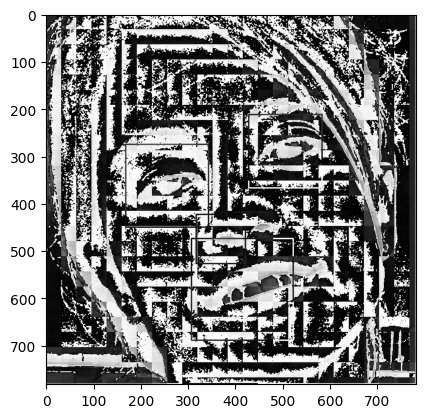

In [17]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

# (3) Preprocessing: Load image, detect face. 

If eyes >=2, then save and crop the face region
Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [18]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

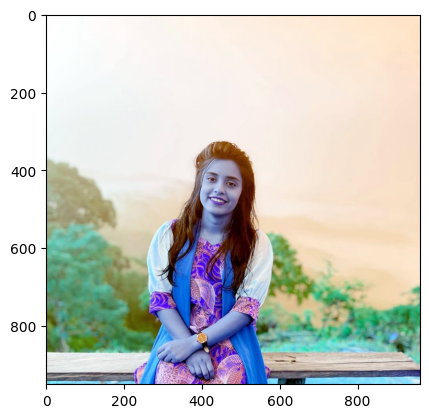

In [19]:
original_image = cv2.imread('../model/test_images/anny2.jpg')
plt.imshow(original_image)

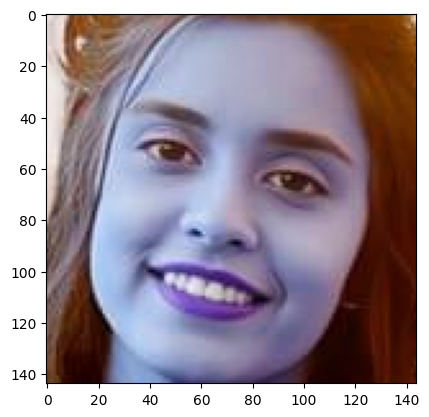

In [20]:
cropped_image = get_cropped_image_if_2_eyes('../model/test_images/anny2.jpg')
plt.imshow(cropped_image)

In below image face is not very clear and it doesn't have two eyes clearly visible

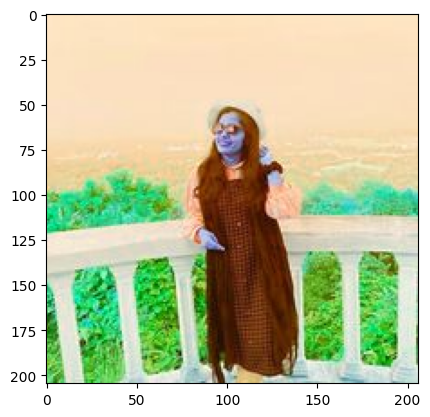

In [21]:
org_image_obstructed = cv2.imread('../model/test_images/anny1.jpg')
plt.imshow(org_image_obstructed) 

In [22]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('../model/test_images/anny1.jpg')
cropped_image_no_2_eyes

Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training

In [23]:
path_to_data = "dataset//"
path_to_cr_data = "dataset//cropped//"

In [24]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [25]:
img_dirs

['dataset//Anny',
 'dataset//Choity',
 'dataset//Emon',
 'dataset//Shova',
 'dataset//Utsho']

In [26]:
#removing if the folder already containing anything
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [27]:
import cv2

def get_cropped_image_if_2_eyes(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if img is None:
        print(f"Failed to load image at {image_path}")
        return None
    
    # Convert the image to grayscale
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except cv2.error as e:
        print(f"Error converting image to grayscale at {image_path}: {e}")
        return None
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        # Detect eyes within the face
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        # If exactly two eyes are detected, return the cropped face image
        if len(eyes) == 2:
            return roi_color
    
    # Return None if conditions are not met
    return None

In [28]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  dataset//cropped//Anny
Generating cropped images in folder:  dataset//cropped//Choity
Generating cropped images in folder:  dataset//cropped//Emon
Generating cropped images in folder:  dataset//cropped//Shova
Generating cropped images in folder:  dataset//cropped//Utsho


<b>Now you should have cropped folder under datasets folder that contains cropped images
Manually examine cropped folder and delete any unwanted images </b>

In [30]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Anny': ['dataset//cropped//Anny\\Anny1.png',
  'dataset//cropped//Anny\\Anny5.png',
  'dataset//cropped//Anny\\Anny6.png',
  'dataset//cropped//Anny\\Anny7.png',
  'dataset//cropped//Anny\\Anny8.png'],
 'Choity': ['dataset//cropped//Choity\\Choity1.png',
  'dataset//cropped//Choity\\Choity10.png',
  'dataset//cropped//Choity\\Choity12.png',
  'dataset//cropped//Choity\\Choity4.png',
  'dataset//cropped//Choity\\Choity5.png',
  'dataset//cropped//Choity\\Choity8.png'],
 'Emon': ['dataset//cropped//Emon\\Emon1.png',
  'dataset//cropped//Emon\\Emon2.png',
  'dataset//cropped//Emon\\Emon5.png',
  'dataset//cropped//Emon\\Emon9.png'],
 'Shova': ['dataset//cropped//Shova\\Shova1.png',
  'dataset//cropped//Shova\\Shova10.png',
  'dataset//cropped//Shova\\Shova11.png',
  'dataset//cropped//Shova\\Shova4.png',
  'dataset//cropped//Shova\\Shova5.png',
  'dataset//cropped//Shova\\Shova6.png',
  'dataset//cropped//Shova\\Shova8.png',
  'dataset//cropped//Shova\\Shova9.png'],
 'Utsho': ['dataset/

In [31]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Anny': 0, 'Choity': 1, 'Emon': 2, 'Shova': 3, 'Utsho': 4}

<b>Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now</b>

In [32]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [33]:
len(X[0])

4096

In [34]:
32*32*3 + 32*32

4096

In [35]:
X[0]

array([[132],
       [138],
       [209],
       ...,
       [ 25],
       [213],
       [243]], dtype=uint8)

In [36]:
y[0]

0

In [37]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(39, 4096)

<b>Data cleaning process is done. Now we are ready to train our model </b>

We will use SVM with rbf kernel tuned with heuristic finetuning

In [38]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [39]:
!pip install scikit-learn


In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7

In [42]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.67      1.00      0.80         6

    accuracy                           0.70        10
   macro avg       0.33      0.40      0.36        10
weighted avg       0.50      0.70      0.58        10



c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<b> Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters </b>

In [44]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [45]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [46]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [47]:
!pip install pandas


In [48]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\Anny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Anny\

,model,best_score,best_params
0,svm,0.726667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.693333,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.760000,{'logisticregression__C': 1}


In [49]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [50]:
best_estimators['svm'].score(X_test,y_test)

0.6

In [51]:
best_estimators['random_forest'].score(X_test,y_test)

0.7

In [52]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7

In [53]:
best_clf = best_estimators['svm']

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 6]])

In [55]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [58]:
class_dict

{'Anny': 0, 'Choity': 1, 'Emon': 2, 'Shova': 3, 'Utsho': 4}

<b> Save the trained model </b>

In [59]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

<b>Save class dictionary </b>

In [60]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))